In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.interpolate import interp1d

In [109]:
# Data files from Andrew
# file_30eV = '30eV theory 10° to 36°.txt'
file_30eV = 'CH4_250eV_M3DW_v4 - 30eV.csv'
file_50eV = 'CH4_250eV_M3DW_v4 - 50eV.csv'

In [100]:
def extractData(filename):
    '''open csv files extracted from the xlsx file and extract the angles and data as three arrays.'''
    # with open(filename, 'r') as f:
    # with open(filename, 'r', encoding = 'mac-roman') as f:
    with open(filename, 'r', encoding = 'utf-8-sig') as f:
        contents = f.readlines()
        # print(contents)
        header = contents[3].split(',')
        # print(header)
    # Obtain the fixed angles as a numpy array
    fixedAngles = np.zeros(len(header) - 1)
    for i, angle in enumerate(header[1:]):
        fixedAngles[i] = float(angle.split(' ')[1])
    # print(fixedAngles)

    # Obtain swept angles as a numpy array
    sweptAngles = np.zeros(15)
    data = np.nan * np.ones((15, 17)) # rows, columns
    for i, line in enumerate(contents[4:19]):
        lineList = line.split(',')
        # print(lineList)
        sweptAngles[i] = lineList[0]
        data[i, :] = lineList[1:]
    return fixedAngles, sweptAngles, data

# fixedAngles, sweptAngles, data = extractData(file_30eV)

In [101]:
def dressCrossSectionFigure(saveName = ''):
    '''Formats the previously created figure/plot to my taste'''
    plt.xlabel(r'Analyser Angle $\theta_2$ ($^{\circ}$)')
    plt.ylabel(r'Counts')
    fig = plt.gcf()
    ax = plt.gca()
    xmajorLocator = MultipleLocator(10)
    xminorLocator = MultipleLocator(5)
    ax.xaxis.set_major_locator(xmajorLocator)
    ax.xaxis.set_minor_locator(xminorLocator)
    plt.tick_params(which = 'both', direction = 'in', left='on', top='on', right='on', bottom='on')
    plt.grid()
    ax.grid(linestyle='-', linewidth='0.5', color='gray', alpha=0.2)
    plt.legend()
    if saveName is not '':
        plt.savefig(saveName+'.pdf', bbox_inches='tight', pad_inches=0.25)
        pass
    plt.show()

In [114]:
def dressImshowFigure(aspect = 5):
    '''Formats the previously created imshow figure'''
    plt.xlabel('Swept Angles ($^\circ$)')
    plt.ylabel('Fixed Angles ($^\circ$)')
    ax = plt.gca()
    ax.set_aspect(aspect=ct)
    plt.show()

In [103]:
def interpolateDataSet(fixedAngles, sweptAngles, data, interpSpacing):
    '''Produces interpolated angle and data arrays with default spacing of 0.1'''
    interpFixedAngles = np.arange(fixedAngles.min(), fixedAngles.max() + interpSpacing, interpSpacing)
    interpSweptAngles = np.arange(sweptAngles.min(), sweptAngles.max() + interpSpacing, interpSpacing)
    
    # first interpolate over the swept angles as before
    sweptAngleInterpolatedData = np.zeros((len(interpSweptAngles), len(fixedAngles)))
    for i, counts in enumerate(data.T): # iterate over the fixed angles
        f = interp1d(sweptAngles, counts, kind = 'cubic')
        sweptAngleInterpolatedData[:,i] = f(interpSweptAngles)

    # now interpolate over the fixed angles
    interpolatedData = np.zeros((len(interpSweptAngles), len(interpFixedAngles)))
    for i, counts in enumerate(sweptAngleInterpolatedData): # iterate over swept angles
        f = interp1d(fixedAngles, counts, kind = 'cubic')
        interpolatedData[i,:] = f(interpFixedAngles)
    
    return interpFixedAngles, interpSweptAngles, interpolatedData

# interpFixedAngles, interpSweptAngles, interpolatedData = interpolateDataSet(fixedAngles, sweptAngles, data, 0.1)

In [257]:
def gaussianConvolution1D(data2D, spacing, axis = 0, FWHM = 6):
    """Performs a 1D gaussian convolution with the 2D data array on the chosen axis. Rows by default.
    The gaussian kernel must be equal to or narrower than the data2D axis to be convolved. To minimise the influence
    of edge effects, format data2D so that its dimensions are much larger than the gaussian will be (or shrink FWHM).
    axis = 0 is rows and axis = 1 is columns""" 
    # 3 sigma is 99.73% of a gaussian. If this fits, use it.
    sigma = FWHM/2.355
#     kernelLen = int(3 * (sigma // 0.1) * 2 + 1)
#     # print(kernelLen)
#     if kernelLen > data2D.shape[1]:
#         # print('Warning: gaussian FWHM is probably too wide for valid convolution. Check edge effects.')
#         kernelLen = data2D.shape[1]    
#     xcentre = kernelLen // 2
#     x = np.arange(kernelLen)
    
#     gaussian = np.exp(-(x-xcentre)**2/(2*sigma**2))

    # old way of creating gaussians. Might clip at edges
#     xlimit = 12
#     x = np.arange(-xlimit, xlimit + interpSpacing, interpSpacing)
#     xcentre = 0
#     gaussian = np.exp(-(x-xcentre)**2/(2*sigma**2))

    # new way which creates array that goes to 3 sigma or just smaller than the data set axis length
    length = (data2D.shape[abs(axis - 1)] // 2) - 1
    
    x = np.arange(-length*spacing, length*spacing + spacing, spacing)
    #print(x.size, data2D.shape)
    xcentre = 0
    gaussian = np.exp(-(x-xcentre)**2/(2*sigma**2))
#     plt.figure(dpi = 276)
#     plt.plot(gaussian)
#     plt.show()
    convolvedData = np.zeros(data2D.shape)
    if axis == 0:
        for i, counts in enumerate(data2D):
            convolvedData[i,:] = np.convolve(counts, gaussian, mode = 'same')
    else:
        for i, counts in enumerate(data2D.T):
            convolvedData[:,i] = np.convolve(counts, gaussian, mode = 'same') 
    
    # (roughly) renormalise to previous max
#     convolvedData /= convolvedData.max()
#     convolvedData *= data2D.max()
    
    return convolvedData

# # test use:
# test = np.zeros((100,100))
# test[40:60,25:30] = 1
# plt.figure(dpi = 276)
# plt.imshow(test)
# plt.show()

# blurredRows = gaussianConvolution1D(test, spacing = 0.1, FWHM = 20)
# plt.figure(dpi = 276)
# plt.imshow(blurredRows)
# plt.show()

# blurredColumns = gaussianConvolution1D(test, spacing = 0.1, axis = 1, FWHM = 5)
# plt.figure(dpi = 276)
# plt.imshow(blurredColumns)
# plt.show()

# x = gaussianConvolution1D(blurredRows, spacing = 0.1, axis = 1, FWHM = 5)
# plt.figure(dpi = 276)
# plt.imshow(x)
# plt.show()

In [203]:
def gaussianConvolution2D(data2D, spacing, FWHM = 6):
    
    convolvedData = gaussianConvolution1D(data2D = data2D, spacing = spacing, axis = 0, FWHM = FWHM)
    convolvedData = gaussianConvolution1D(convolvedData, spacing = spacing, axis = 1, FWHM = FWHM)

    return convolvedData

# # test use:
# test = np.zeros((100,100))
# test[40:60,25:30] = 1
# plt.figure(dpi = 276)
# plt.imshow(test)
# plt.show()

# blurred = gaussianConvolution2D(test, spacing = 0.1, FWHM = 20)
# plt.figure(dpi = 276)
# plt.imshow(blurred)
# plt.show()

# plt.figure(dpi = 276)
# plt.plot(test[50,:])
# plt.plot(blurred[50,:])
# plt.show()

### 30 eV theory data:

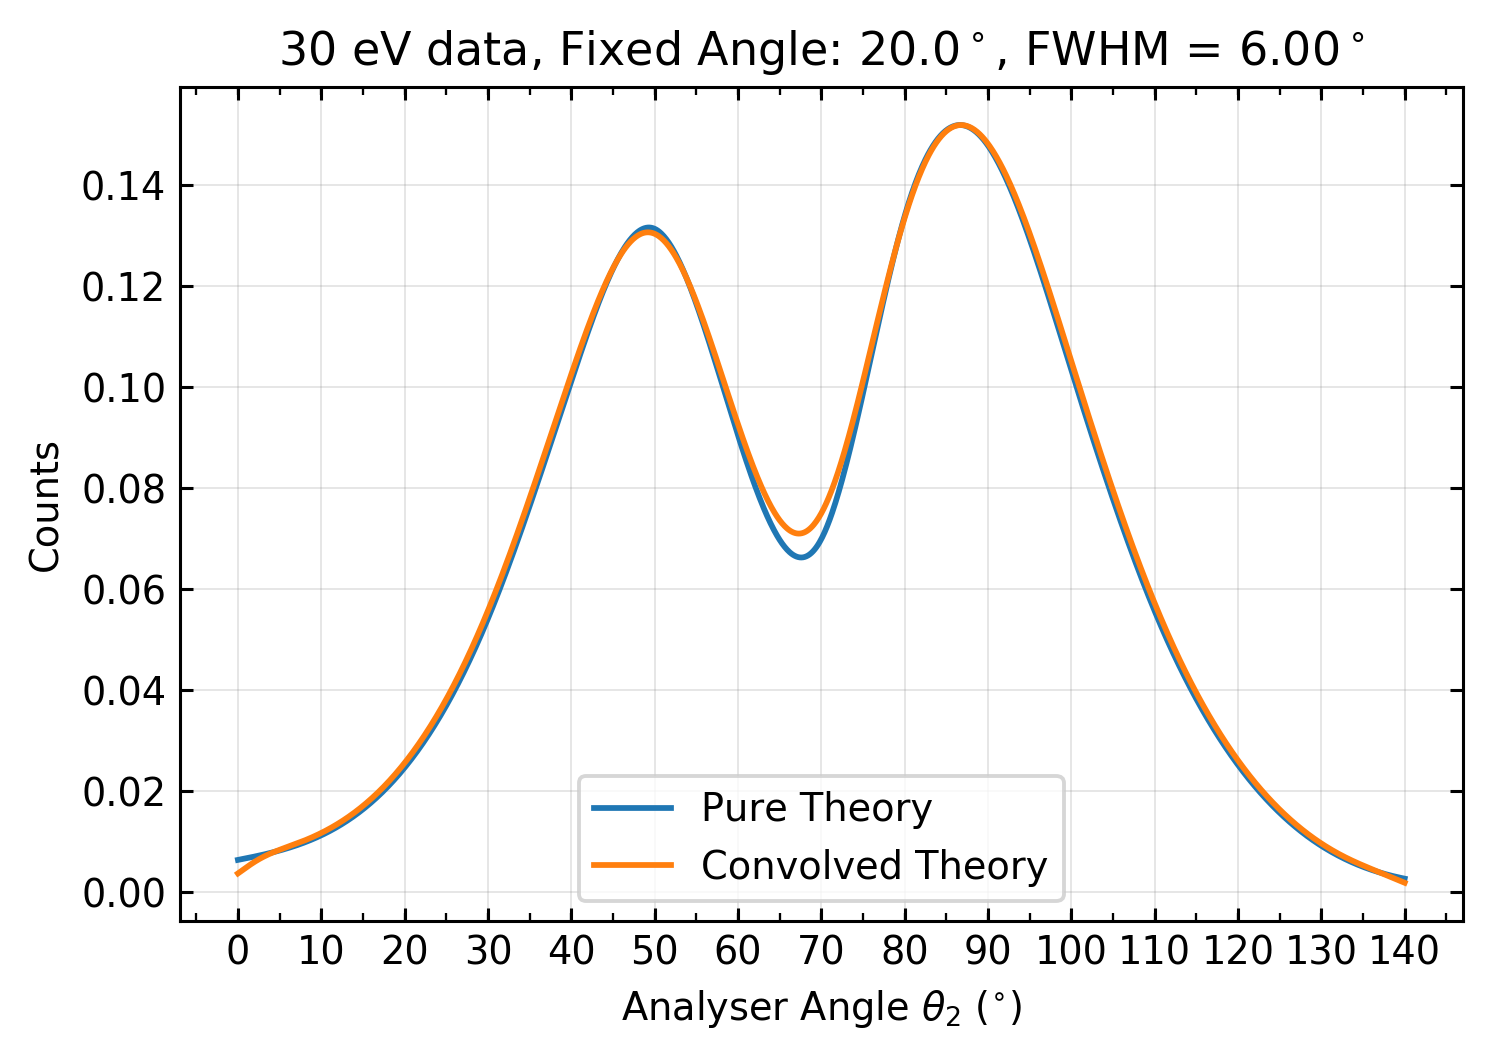

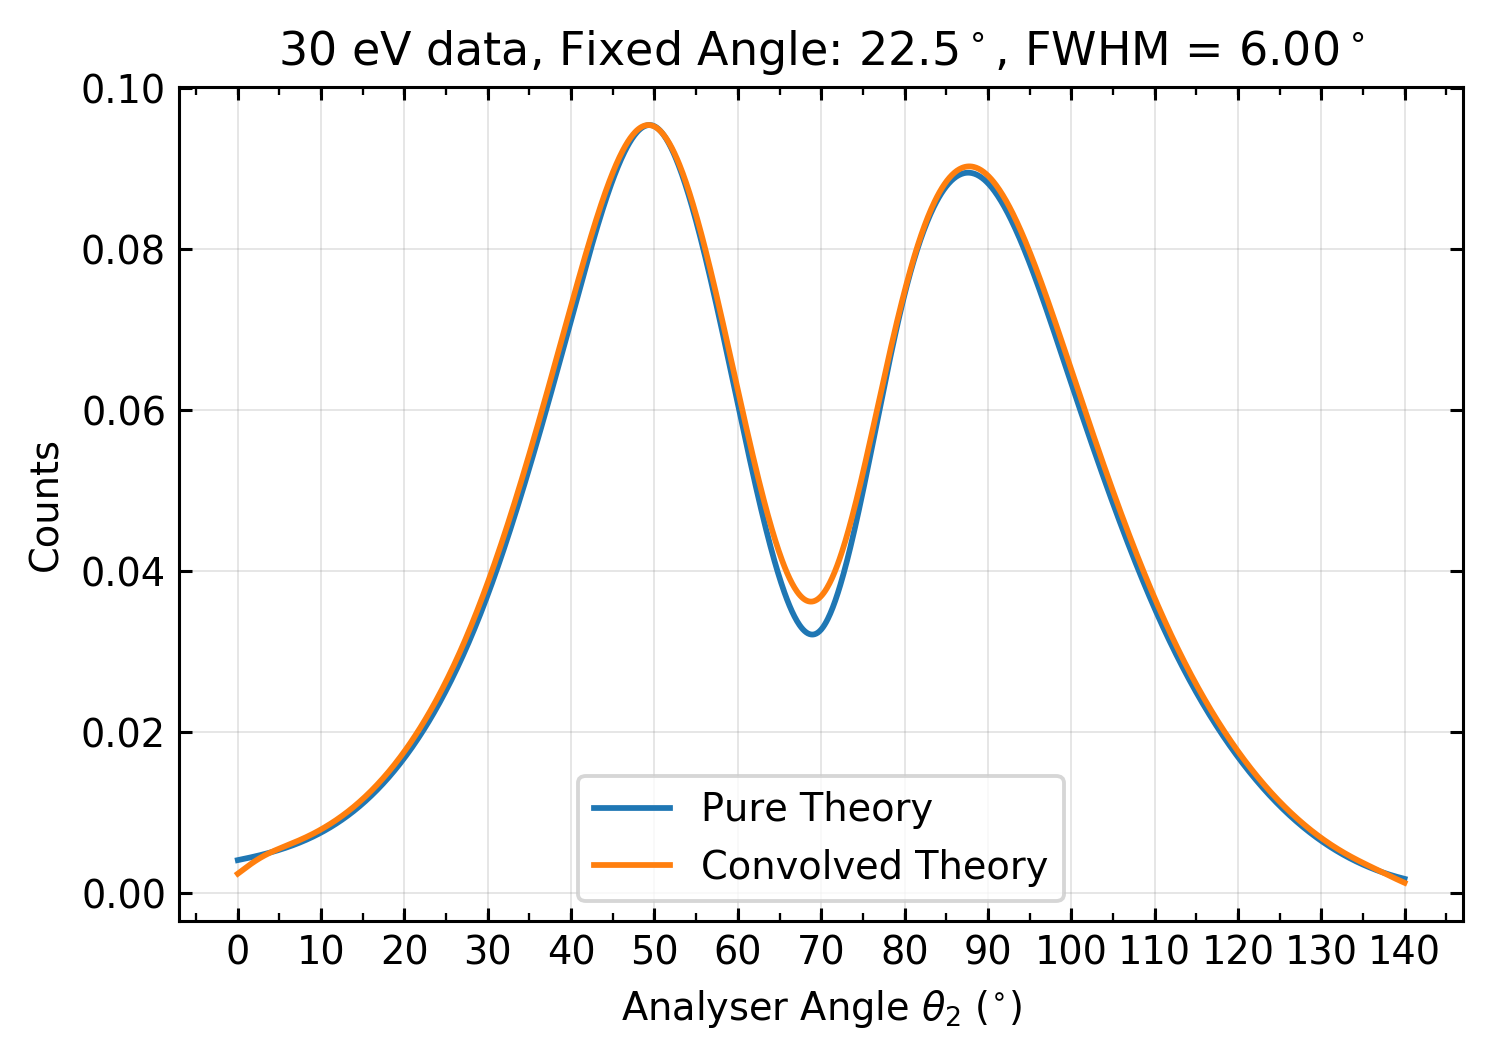

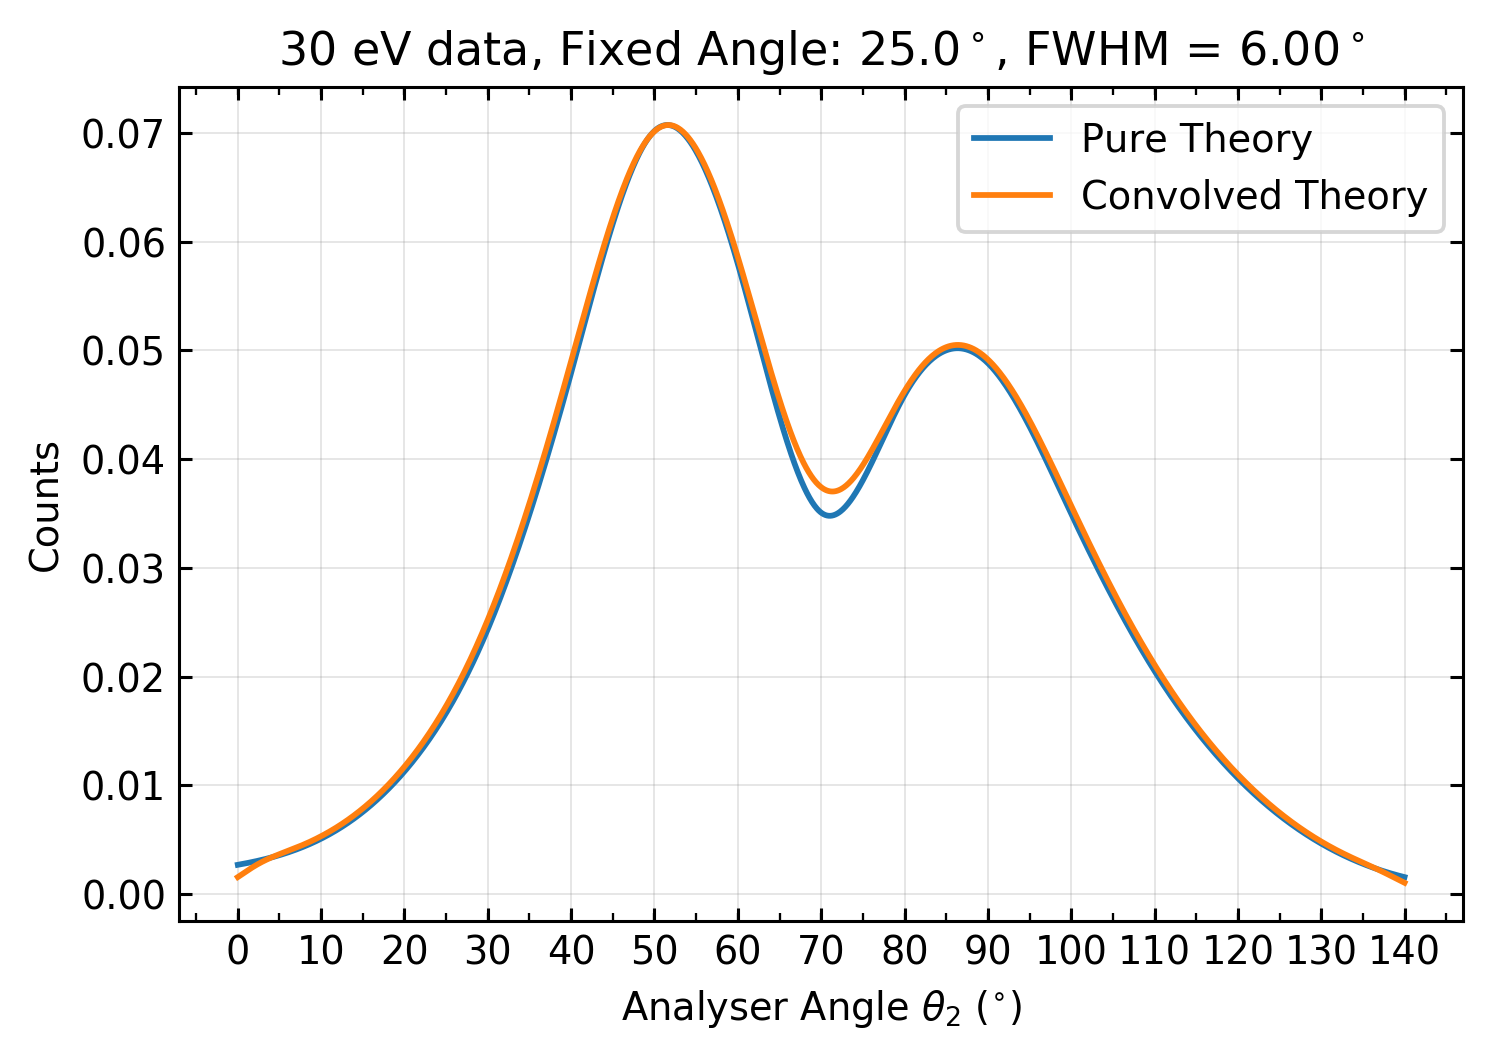

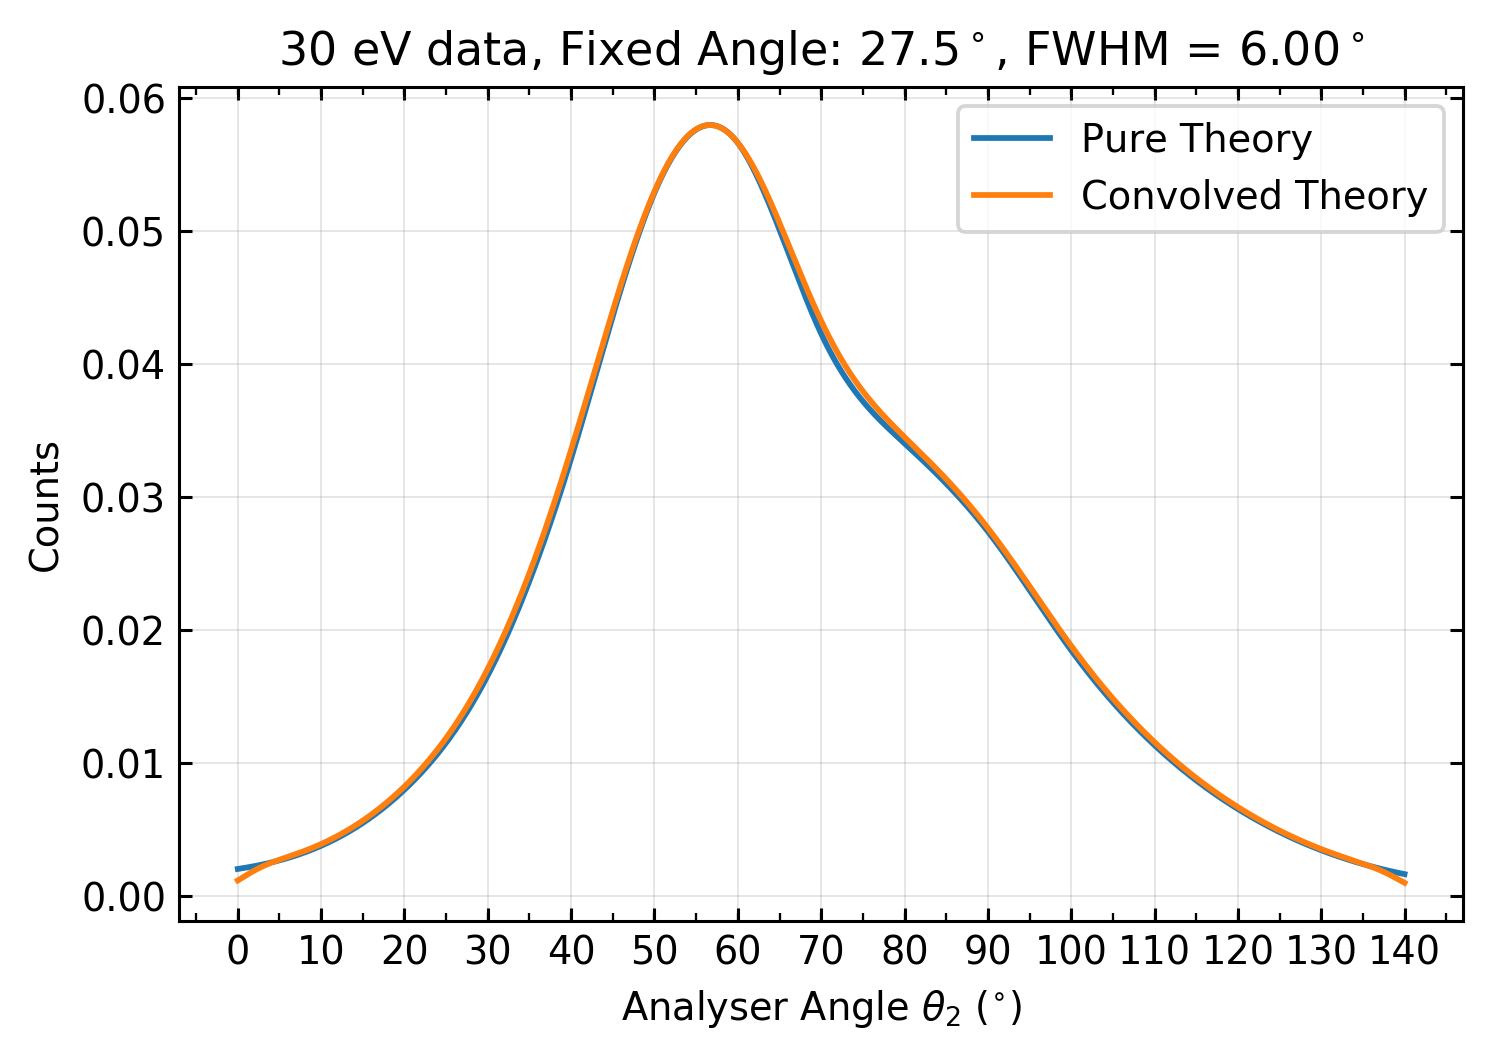

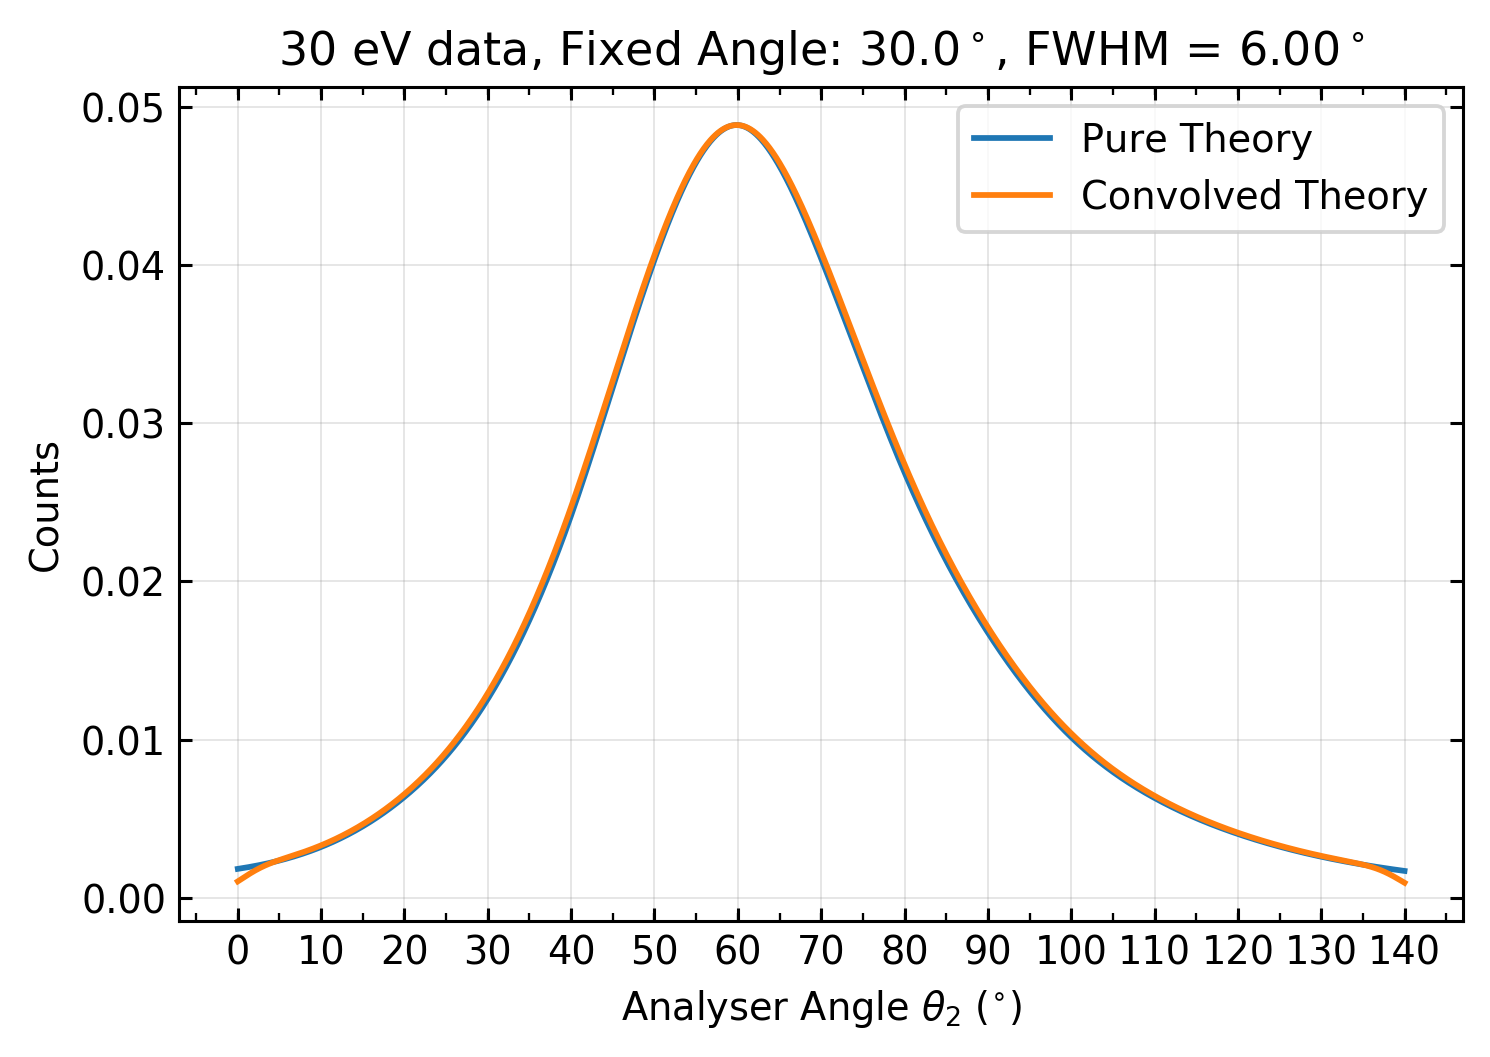

In [261]:
interpSpacing = 0.1
FWHM = 6
fixedAngles, sweptAngles, data = extractData(file_30eV)
#delete 27.5 to see if bump goes away
interpFixedAngles, interpSweptAngles, interpolatedData = interpolateDataSet(fixedAngles, sweptAngles, data, 0.1)
# interpolatedData = np.flip(interpolatedData, 0)

# convolvedData = gaussianConvolution2D(interpolatedData, interpSpacing, FWHM = FWHM)
convolvedData = gaussianConvolution1D(interpolatedData, interpSpacing, axis = 0, FWHM = FWHM) # just fixed angles
convolvedData = gaussianConvolution1D(interpolatedData, interpSpacing, axis = 1, FWHM = FWHM) # just swept angles

# Pick out slices from the theory data where we have experimental fixed angles:
fixedExptAngles = np.array([20, 22.5, 25, 27.5, 30])
fixedTheoryAngIndices = np.zeros(fixedExptAngles.shape)
for i, angle in enumerate(fixedExptAngles):
    index = np.where(np.isclose(interpFixedAngles, angle))[0]
    fixedTheoryAngIndices[i] = index
    normalisedConvolutedData = convolvedData[:, index] / convolvedData[:, index].max()
    normalisedConvolutedData = normalisedConvolutedData * interpolatedData[:, index].max()
    plt.figure(dpi = 276)
    plt.title(f'30 eV data, Fixed Angle: {angle}$^\circ$, FWHM = {FWHM:.2f}$^\circ$')
    plt.plot(interpSweptAngles, interpolatedData[:, index], label = 'Pure Theory')
    plt.plot(interpSweptAngles, normalisedConvolutedData, label = 'Convolved Theory')
    dressCrossSectionFigure()

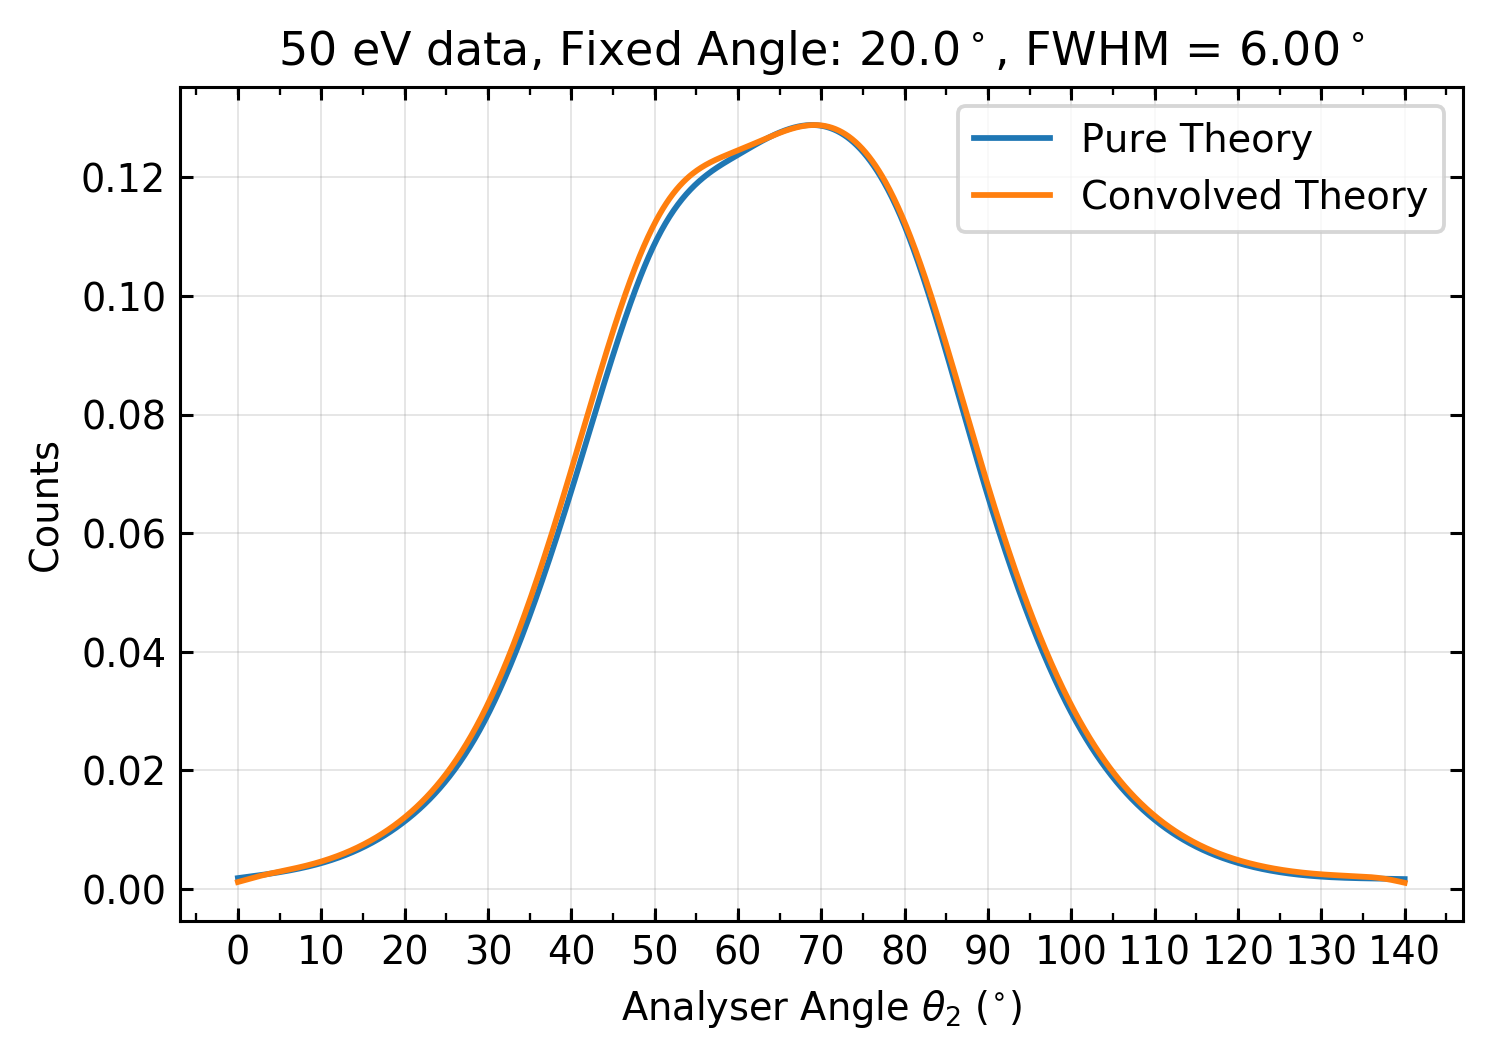

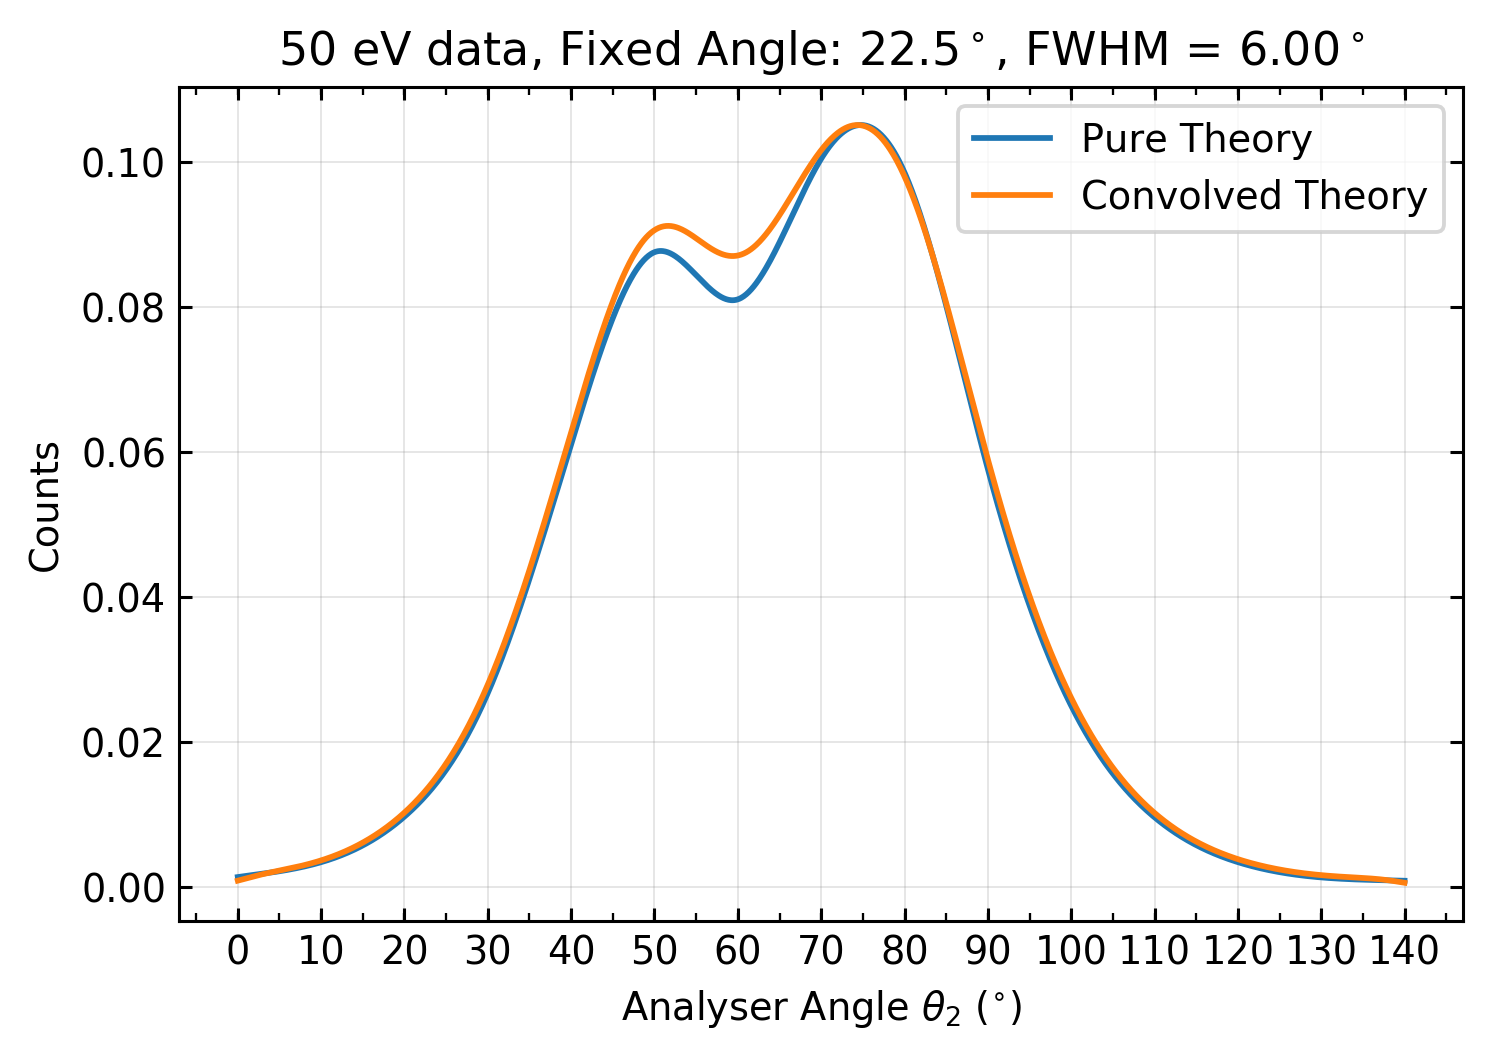

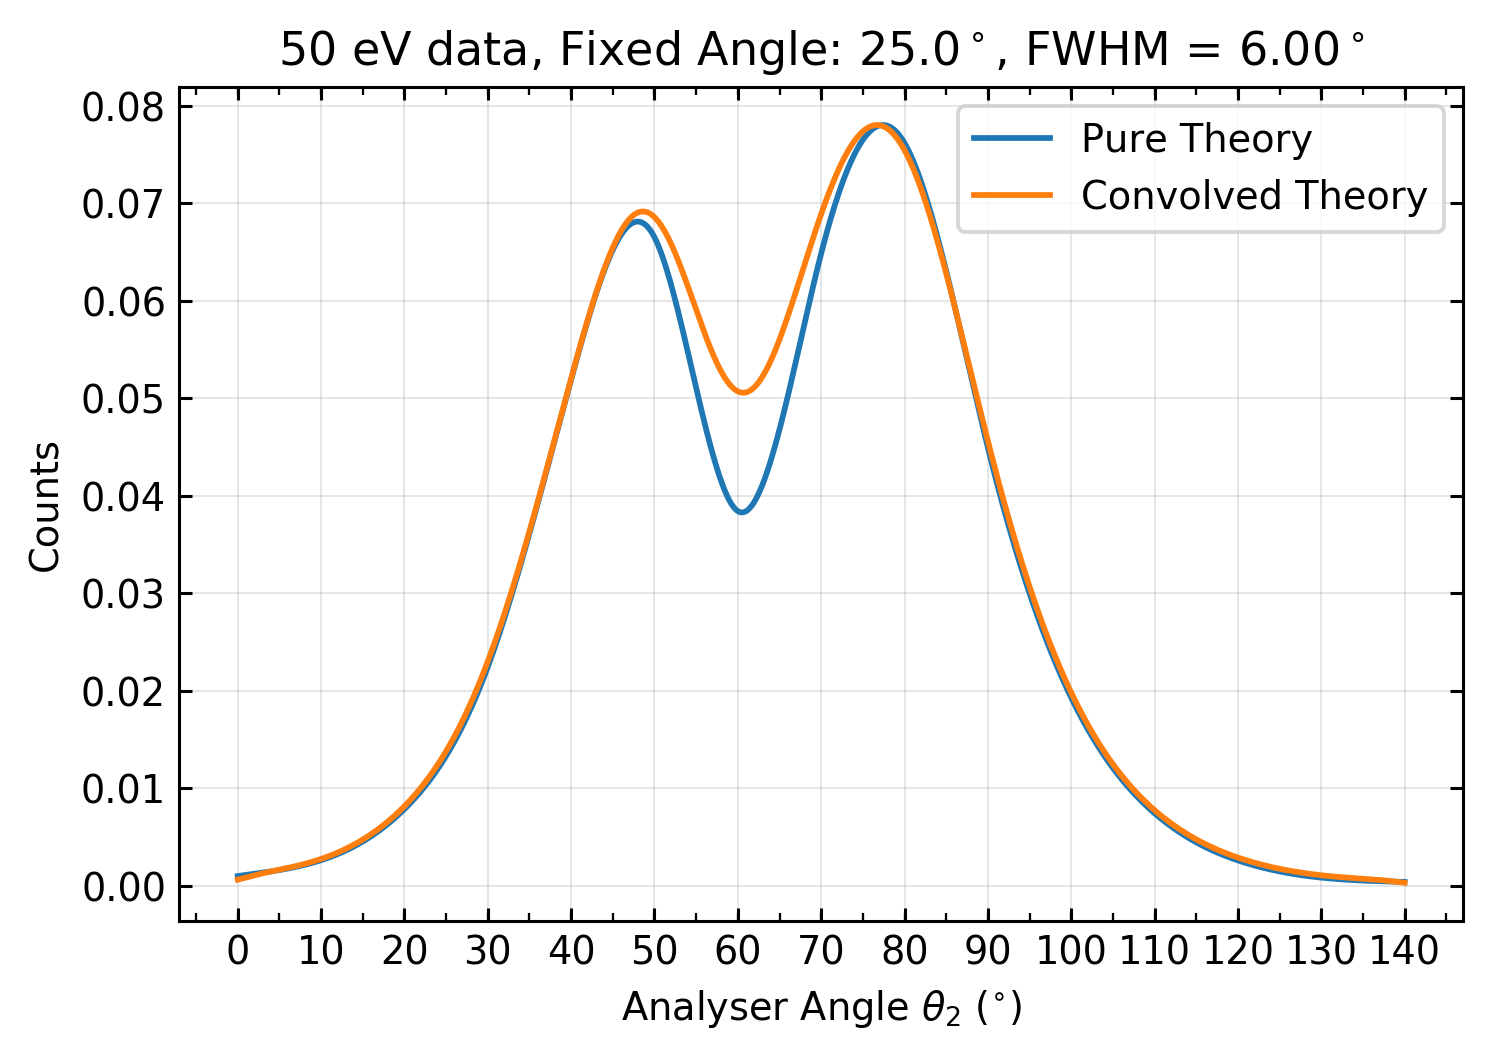

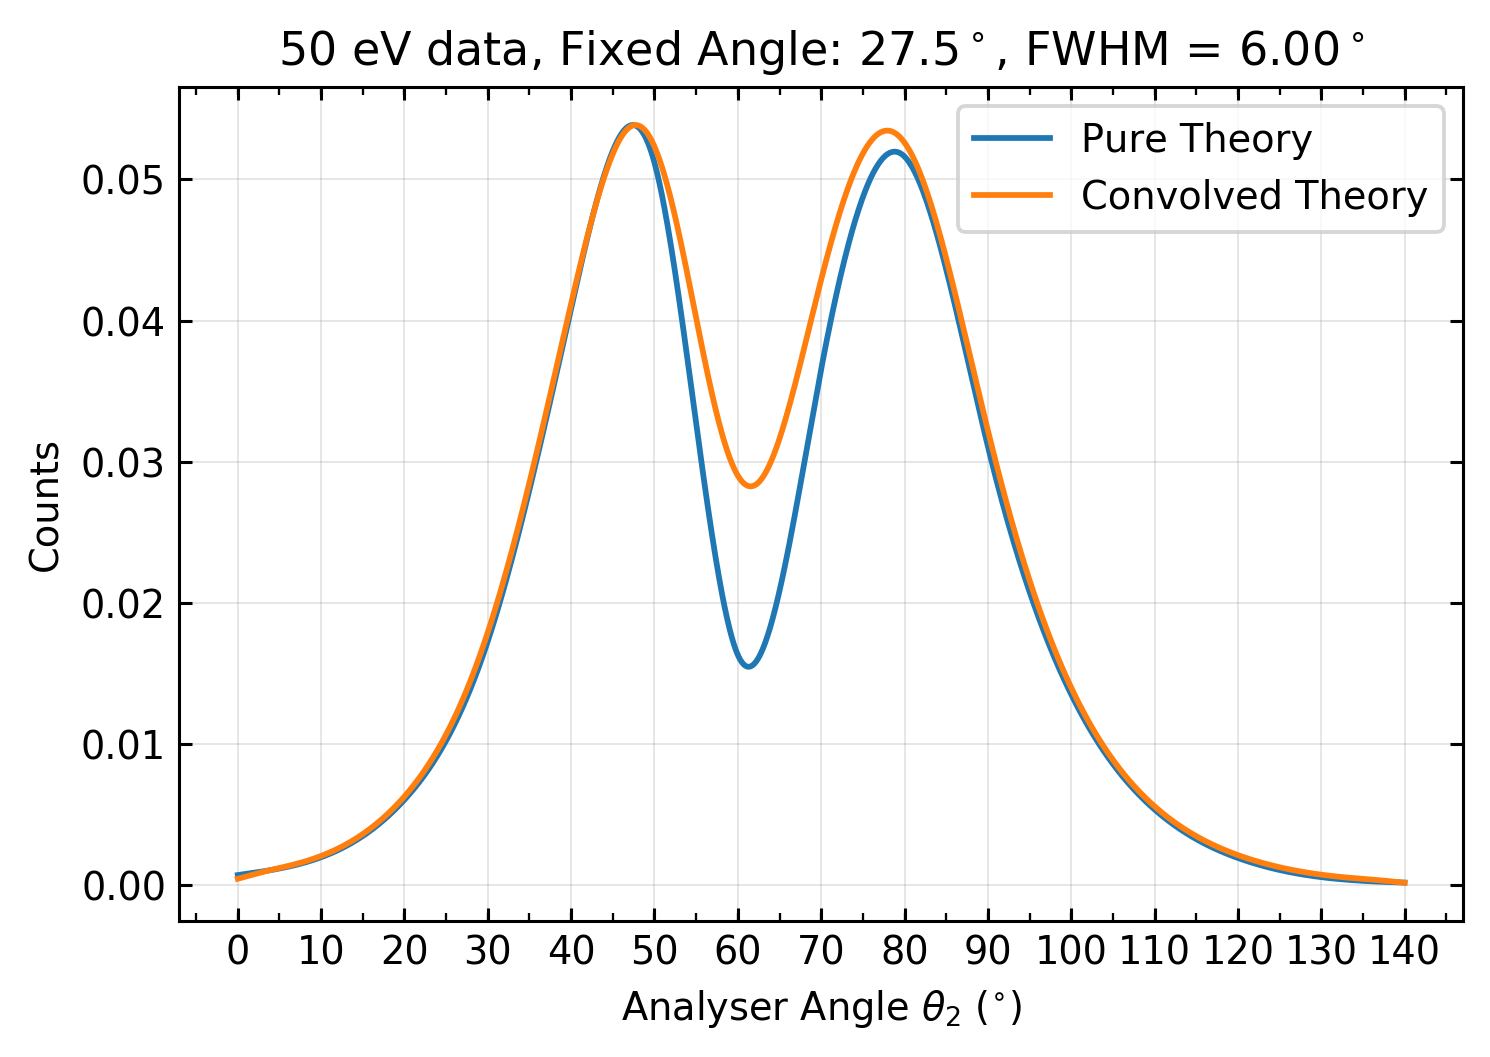

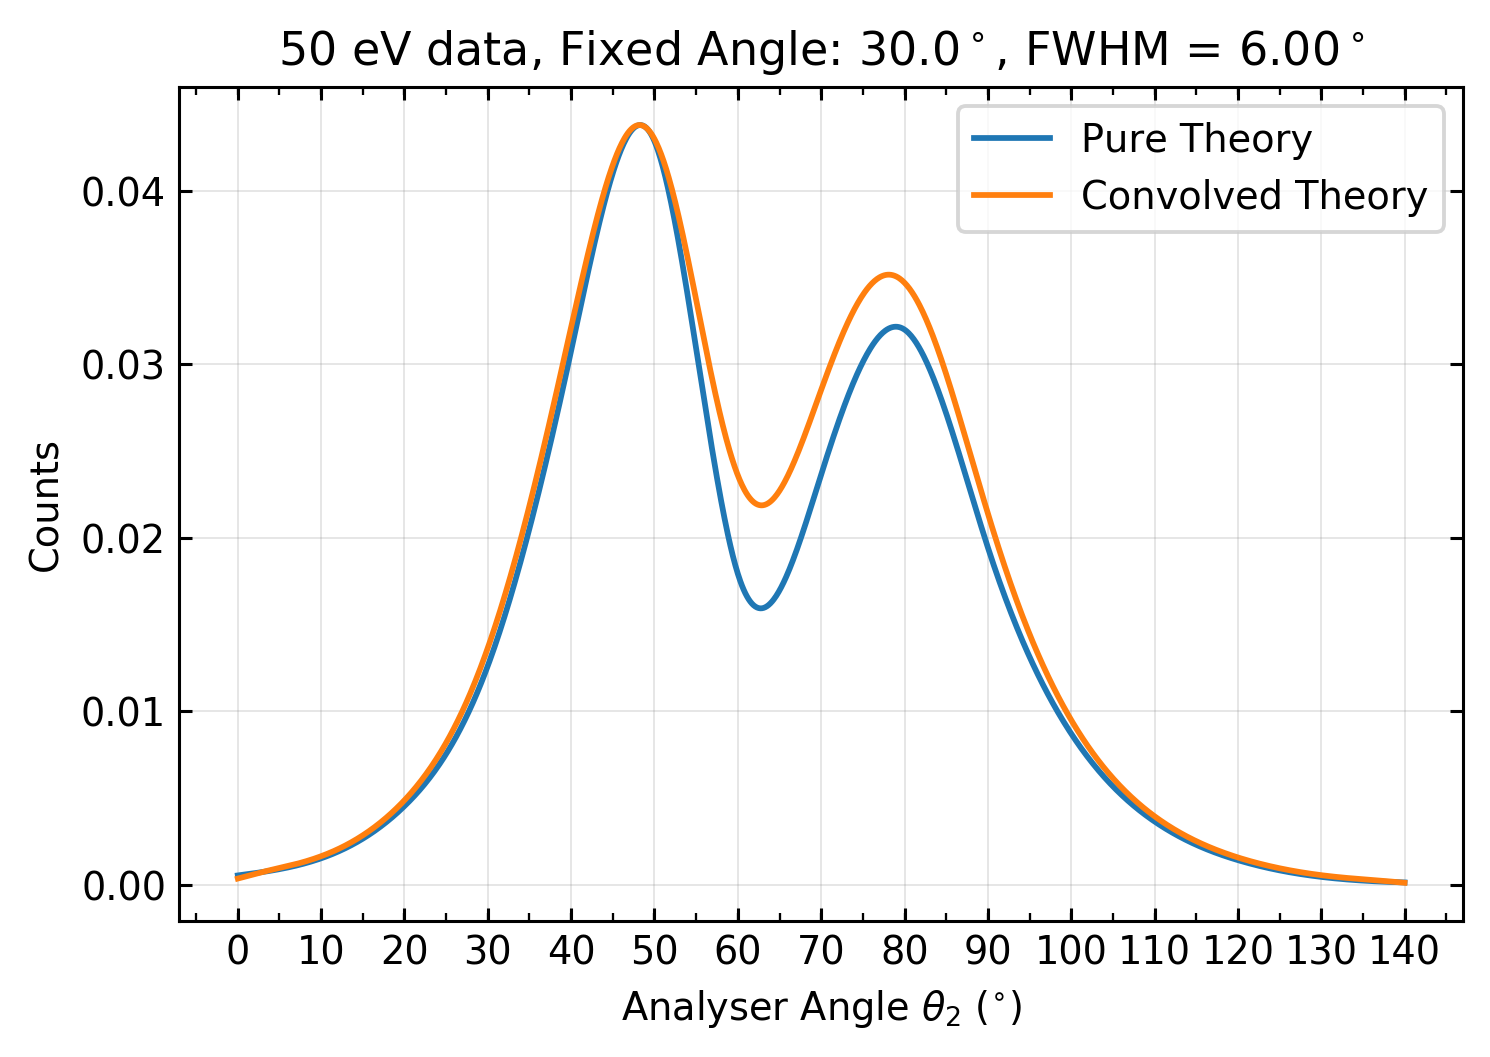

In [259]:
interpSpacing = 0.1
FWHM = 6
fixedAngles, sweptAngles, data = extractData(file_50eV)
interpFixedAngles, interpSweptAngles, interpolatedData = interpolateDataSet(fixedAngles, sweptAngles, data, 0.1)
# interpolatedData = np.flip(interpolatedData, 0)
convolvedData = gaussianConvolution2D(interpolatedData, interpSpacing, FWHM = FWHM)

# Pick out slices from the theory data where we have experimental fixed angles:
fixedExptAngles = np.array([20, 22.5, 25, 27.5, 30])
fixedTheoryAngIndices = np.zeros(fixedExptAngles.shape)
for i, angle in enumerate(fixedExptAngles):
    index = np.where(np.isclose(interpFixedAngles, angle))[0]
    fixedTheoryAngIndices[i] = index
    normalisedConvolutedData = convolvedData[:, index] / convolvedData[:, index].max()
    normalisedConvolutedData = normalisedConvolutedData * interpolatedData[:, index].max()
    plt.figure(dpi = 276)
    plt.title(f'50 eV data, Fixed Angle: {angle}$^\circ$, FWHM = {FWHM:.2f}$^\circ$')
    plt.plot(interpSweptAngles, interpolatedData[:, index], label = 'Pure Theory')
    plt.plot(interpSweptAngles, normalisedConvolutedData, label = 'Convolved Theory')
    dressCrossSectionFigure()

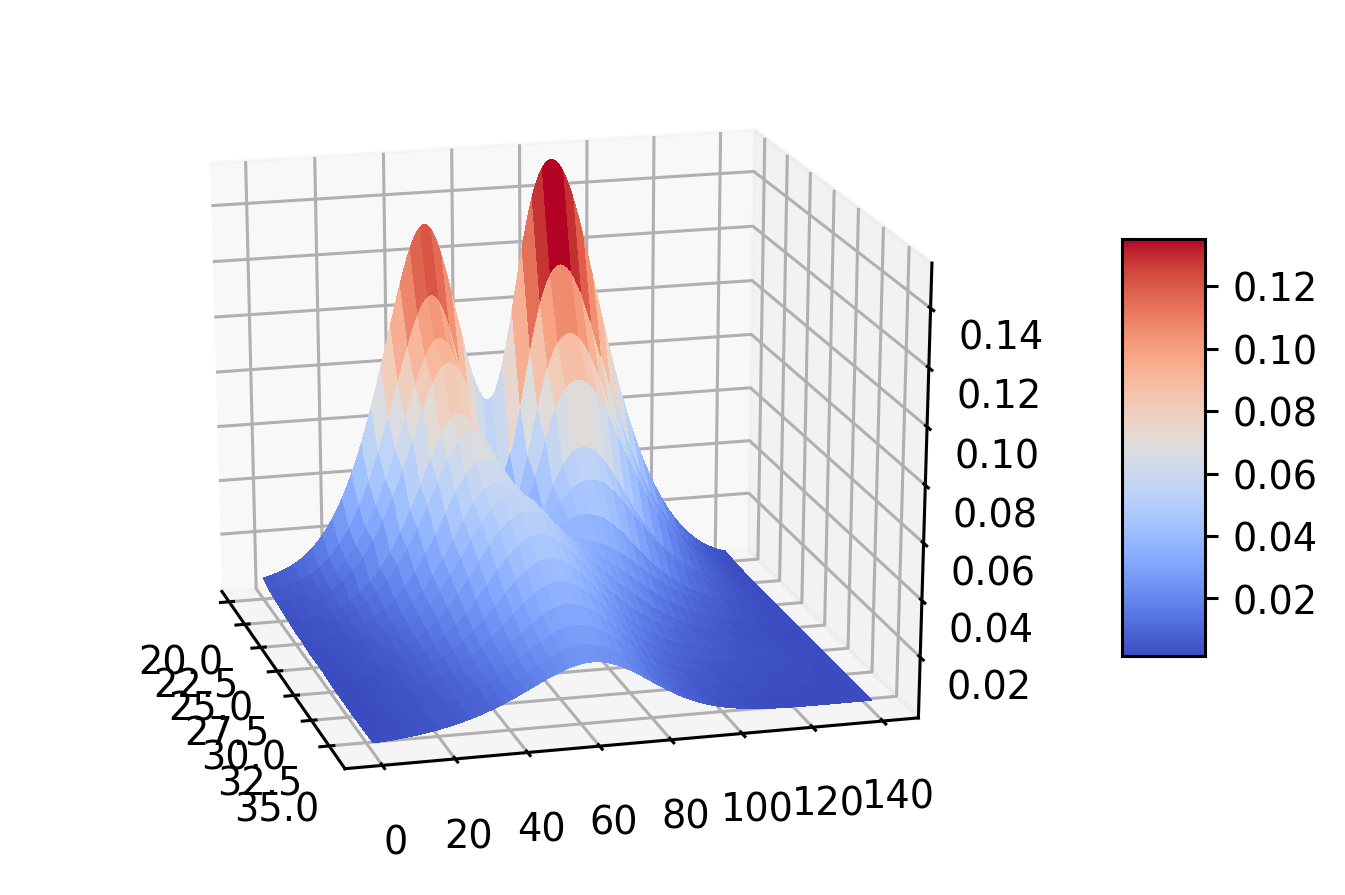

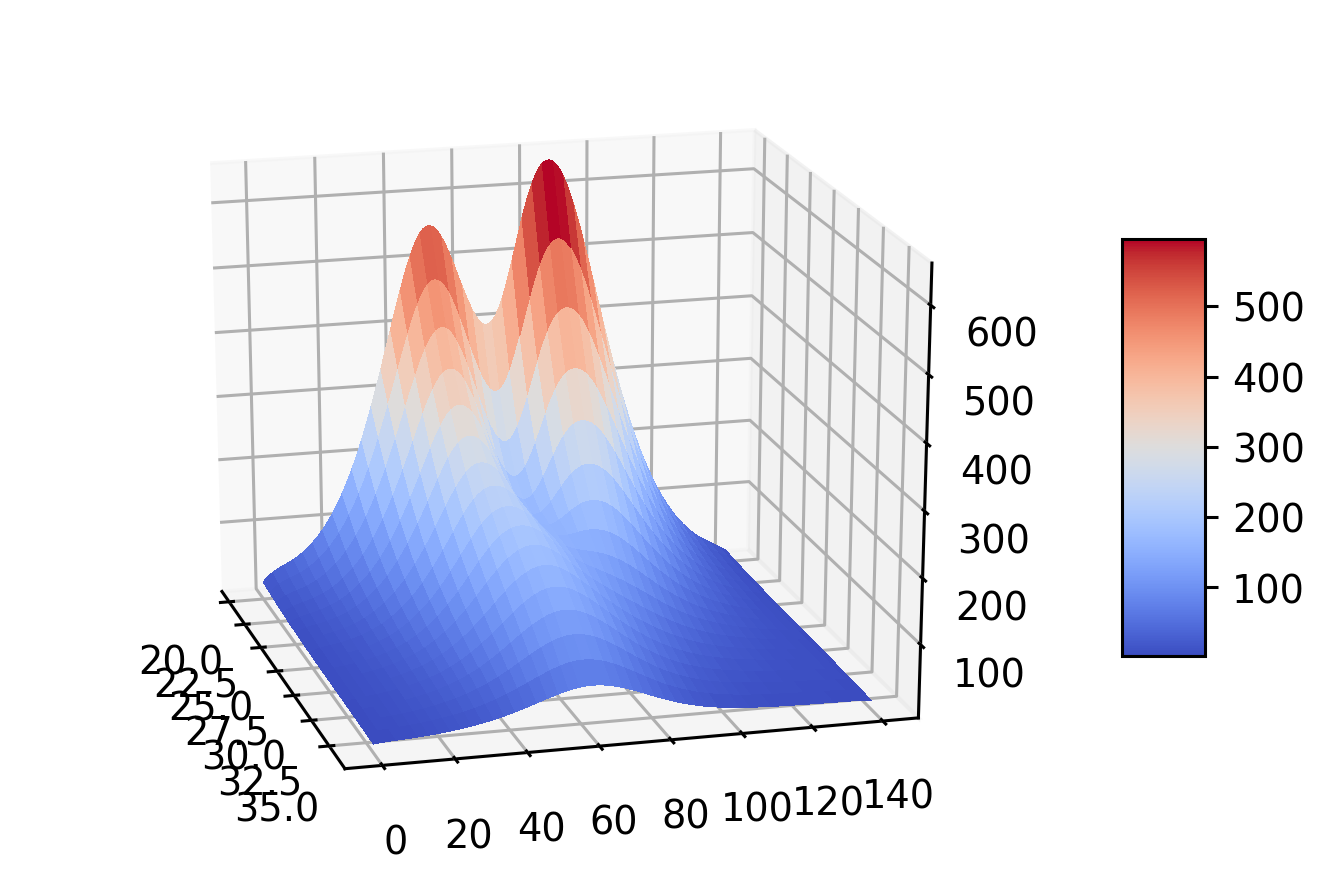

In [254]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

# % matplotlib inline
fig = plt.figure(dpi = 276)
# fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X, Y = np.meshgrid(interpFixedAngles[100:], interpSweptAngles)


# # Plot the surface.
surf = ax.plot_surface(X[::10,::10], Y[::10,::10], interpolatedData[::10,100::10], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=20, azim=-15)
plt.show()

# % matplotlib inline
fig = plt.figure(dpi = 276)
# fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X, Y = np.meshgrid(interpFixedAngles[100:], interpSweptAngles)


# # Plot the surface.
surf = ax.plot_surface(X[::10,::10], Y[::10,::10], convolvedData[::10,100::10], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(elev=20, azim=-15)
plt.show()